# PrivacyNet on MNIST data.

In [1]:
import numpy as np
from keras.datasets import mnist
import random

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.convolutional import UpSampling2D
from keras.layers import Conv2D, MaxPooling2D,LeakyReLU,Conv2DTranspose
from keras.layers import Input, Lambda, concatenate, Add, Concatenate
from keras import backend as K

from keras.optimizers import Adam, RMSprop

In [4]:
from privacy_net.utils.module import u_tail
from privacy_net.utils.module import y_tail
from privacy_net.utils.module import InstanceNormalization2D
from privacy_net.utils.module import residual_block
from privacy_net.models.privacy_net_model import privacyNet

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def generator(img):
    #     def tileAttr(x):
    #         x = tf.expand_dims(x, axis = 1)
    #         x = tf.expand_dims(x, axis = 2)
    #         return tf.tile(x, [1, size, size, 1])

    #     y = Concatenate()([img, Lambda(tileAttr)(attr)])

    y = Conv2D(32, 5, padding="same", kernel_initializer='he_normal')(img)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(64, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(128, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)

    y = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2DTranspose(32, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = Activation('tanh')(y)
    return y

In [6]:
def discriminator(img, u_size, y_size, u_feat_dims=None, y_feat_dims=None, activation='tanh'):
    #     def tileAttr2(x):
    #         x = tf.expand_dims(x, axis = 1)
    #         x = tf.expand_dims(x, axis = 2)
    #         return tf.tile(x, [1, size//64, size//64, 1])

    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)

    pred_real = Conv2D(1, kernel_size=2, strides=1, kernel_initializer='he_normal')(y)
    pred_f_u = []
    pred_g_y = []
    if not u_feat_dims:
        u_feat_dims = [2 for _ in range(u_size)]
    if not y_feat_dims:
        y_feat_dims = [2 for _ in range(y_size)]

    for i in range(u_size):
        temp_u = Conv2D(u_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_u = Flatten()(temp_u)
        pred_f_u.append(temp_u)

    for i in range(y_size):
        temp_y = Conv2D(y_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_y = Flatten()(temp_y)
        pred_g_y.append(temp_y)

    return pred_real, pred_f_u, pred_g_y

In [7]:
def generatorV2(img):

    
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='relu')(trans_x)
    trans_x = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(trans_x)
    trans_x = Activation('tanh')(trans_x)
    return trans_x

In [8]:
def generatorV3(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='tanh')(trans_x)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [9]:
def generatorV4(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(96, kernel_size=3,
                         padding='same',
                         activation='tanh')(img)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [7]:
def save_some(im_list,name):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.savefig(name)

# Reversed digits experiment

In [8]:
class reversedMNISTGenerator():
    def __init__(self, batch_size=16):

        self.input_shape = (28, 28, 1)
        self.batch_size = batch_size
        (self.x_train, self.digit_train), (self.x_test, self.digit_test) = mnist.load_data()
        self.x_train = np.expand_dims(self.x_train, axis=-1)
        self.x_test = np.expand_dims(self.x_test, axis=-1)
        
        self.x_train = np.concatenate((self.x_train,255-self.x_train),axis=0)
        self.x_test = np.concatenate((self.x_test,255-self.x_test),axis=0)
        self.digit_train = np.concatenate((self.digit_train,self.digit_train),axis=0)
        self.digit_test = np.concatenate((self.digit_test,self.digit_test),axis=0)
        
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        
        self.u_train, self.u_test = self.load_public_label()
        self.y_train, self.y_test = self.load_sensitive_label()
        
        self.steps_per_epoch = self.default_training_steps
        self.test_steps = self.default_testing_steps

        self.cur_train_step = 0
        self.cur_test_step = 0
        self.train_ind_list = np.array([i for i in range(self.train_size)])
        self.test_ind_list = np.array([i for i in range(self.test_size)])
        random.seed(1234)
        random.shuffle(self.train_ind_list)
#         random.shuffle(self.test_ind_list)

    # property is a getter
    @property
    def default_training_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.train_size / self.batch_size))

    @property
    def default_testing_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.test_size / self.batch_size))

    def load_public_label(self):
        # prepare utility labels
#         u_train = np.zeros_like(self.digit_train)
#         u_test = np.zeros_like(self.digit_test)

#         u_train[self.digit_train % 2 == 1] = 1
#         u_test[self.digit_test % 2 == 1] = 1

        return self.digit_train, self.digit_test

    def load_sensitive_label(self):
        # prepare privacy labels
        y_train = np.zeros_like(self.digit_train)
        y_test = np.zeros_like(self.digit_test)
        
        y_train[int(self.train_size/2):] = 1
        y_test[int(self.test_size/2):] = 1
        return y_train, y_test

    def nextTrain(self):
        while True:

            # set self.cur_train_ind
            # cur_train_ind has indices of batch_sizes, this indices correpond to the image ids
            self.fetchCurrentTrainInd()
            train_x = self.x_train[self.cur_train_ind]
            train_x = train_x / 127.5 - 1

            train_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                train_u[i][self.u_train[self.cur_train_ind[i]]] = 1
            train_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                train_y[i][self.y_train[self.cur_train_ind[i]]] = 1

            inputs = {'input_x': train_x, 'input_y': [train_y], 'input_u': [train_u]}
            output = np.zeros((self.batch_size, 1))
            self.cur_train_step += 1
            yield inputs, output

    def fetchCurrentTrainInd(self):
        # this function find cur_train_ind for each step
        # it read batch_size's image_ids, starting from cur_train_step(batch_size,augment_ratio)

        # if self.cur_train_step%self.augment_ratio != 0:
        #     return

        # when epoch end it will shuffle image_ids and reset cur_train_step, namely, read from the start
        if self.cur_train_step >= self.steps_per_epoch:
            random.shuffle(self.train_ind_list)
            # print("shuffling")
            self.cur_train_step = 0

        cur_train_start = int(self.cur_train_step) * self.batch_size
        cur_train_end = cur_train_start + self.batch_size
        if cur_train_end > self.train_size:
            cur_train_end = self.train_size
        self.cur_train_ind = self.train_ind_list[np.arange(cur_train_start, cur_train_end).astype(int)]

    def nextVal(self):
        while True:
            if self.cur_test_step == self.test_steps:
                self.cur_test_step = 0
                random.shuffle(self.test_ind_list)
            cur_test_start = int(self.cur_test_step) * self.batch_size
            cur_test_end = cur_test_start + self.batch_size
            if cur_test_end > self.test_size:
                cur_test_end = self.test_size
            self.cur_test_ind = self.test_ind_list[np.arange(cur_test_start, cur_test_end)]

            test_x = self.x_test[self.cur_test_ind]
            test_x = test_x / 127.5 - 1

            test_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                test_u[i][self.u_test[self.cur_test_ind[i]]] = 1
            test_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                test_y[i][self.y_test[self.cur_test_ind[i]]] = 1

            self.cur_test_step += 1
            inputs = {'input_x': test_x, 'input_y': [test_y], 'input_u': [test_u]}
            output = np.zeros((self.batch_size, 1))
            yield inputs, output

In [12]:
import time
import datetime
class privacyNetV3(privacyNet):

    def __init__(self, u_input_dims=[2, 2, 2, 2], y_input_dims=[2], u_feat_dims=[2, 2, 2, 2],
                 y_feat_dims=[2],mode=0,
                 **kwargs):
        self.u_input_dims = u_input_dims
        self.y_input_dims = y_input_dims
        self.u_feat_dims = u_feat_dims
        self.y_feat_dims = y_feat_dims
        self.mode = mode # 0->generatorV2 1->generatorV3 2->generatorV4
        super(privacyNetV3, self).__init__(**kwargs)

    def build_model(self):

        """Build Discriminator and Generator and Transformer, seperately.
        This method requires no inputs and returns nothing.
        self.d_model, self.g_model, self.transform_tail_models are goals for this method.
        NOTE: The following 'Output's and 'Input's are used for introducing model specs.

        # D model arguments:
            - d_model: Discriminator part.
        Input:
            - attr_y_input: list of Input Tensors. sensitive labels, Y.
            - attr_u_input(Optional): list, of Input Tensors. public labels, U.
            - img_input: Input Tensor, shared with g_model. raw images, X.
        Output:
            - loss_y_output: list, H-score between imgs and sensitive labels. H_score.
            - loss_u_output: list, H-score between imgs and public labels. Might be None. H_score
            - pred_real: predictions of real images. prob.
            - pred_f_y: list, feature of Y. y(X).
            - pred_f_u: list, feature of U. u(X).

        # G model:
            - g_model: Generator part.
        Input:
            - img_input: Input Tensor, shared with d_model. raw images, X.
        Output:
            - img_output: transformed images. transformed images, Z.

        # T models:
            - transform_tail_models: list of T models.
        Input:
            - transform_y_input: list of input of third networks in order to filter
                                 sensitive information. y(Z)
        Output:
            - transform_y_tail: list. h(y(Z))

        """
        ################## Part I ######################
        ## start building D model
        self.img_input = Input(self.image_size)
        self.attr_y_input = [] # placeholder for every sensitive labels
        self.attr_u_input = [] # placeholder for every public labels

        for i in range(self.y_size):
            self.attr_y_input.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u_input.append(Input((self.u_input_dims[j],)))

        self.pred_real, self.pred_f_u, self.pred_f_y = discriminator(self.img_input,
                                                         self.u_size,
                                                         self.y_size,
                                                         self.u_feat_dims,
                                                         self.y_feat_dims,
                                                         activation=self.activation)

        # All tail networks are separated
        self.attr_y_tail = [] # holding tails network for sensitive_attrs
        self.attr_u_tail = [] # holding tails network for public_attrs


        for i in range(self.y_size):
            self.attr_y_tail.append(y_tail(self.attr_y_input[i],
                                           self.y_feat_dims[i],
                                           activation=self.activation))

        for j in range(self.u_size):
            self.attr_u_tail.append(u_tail(self.attr_u_input[j],
                                           self.u_feat_dims[j],
                                    activation = self.activation))

        self.loss_y_output = [] # containing sensitive H-score
        self.loss_u_output = [] # containing public H-score

        for i in range(self.y_size):
            self.loss_y_output.append(Lambda(self.neg_hscore)([self.pred_f_y[i], self.attr_y_tail[i]]))

        for j in range(self.u_size):
            self.loss_u_output.append(Lambda(self.neg_hscore)([self.pred_f_u[j], self.attr_u_tail[j]]))

        self.d_model = Model(inputs=[self.img_input] + self.attr_u_input + self.attr_y_input,
                             outputs=[self.pred_real] + self.loss_u_output + self.loss_y_output
                                     + self.pred_f_u + self.pred_f_y + self.attr_u_tail + self.attr_y_tail)
        if self.d_model_dir:
            self.d_model.load_weights(self.d_model_dir)  # load pretrained model if avialable
        ## end building D model

        ################## Part II ######################
        ## start building G model
        if self.mode == 0:
            self.img_output = generatorV2(self.img_input)  # pass image into generator
        elif self.mode == 1:
            self.img_output = generatorV3(self.img_input)  # pass image into generator
        elif self.mode == 2:
            self.img_output = generatorV4(self.img_input)  # pass image into generator
        else:
            self.img_output = generator(self.img_input)  # pass image into generator
            
        self.g_model = Model(inputs=[self.img_input], outputs=[self.img_output])

        if self.g_model_dir:
            self.g_model.load_weights(self.g_model_dir) # load pretrained model if avialable
        ## end building G model

        ################## Part III ######################
        ## start building T model
        self.transform_y_input = [] # T model inputs
        for i in range(self.y_size):
            self.transform_y_input.append(Input((self.y_feat_dims[i],)))

        self.transform_y_tail = []  # T model outputs
        for i in range(self.y_size):
            self.transform_y_tail.append(y_tail(self.transform_y_input[i],
                                                self.y_feat_dims[i],
                                           activation=self.activation))
        self.transform_tail_models = []
        for i in range(self.y_size):
            self.transform_tail_models.append(Model(inputs=[self.transform_y_input[i]],
                                                    outputs=[self.transform_y_tail[i]]))
        if self.t_model_y_dir:
            for ind_y in range(self.y_size):
                self.transform_tail_models[ind_y].load_weights(self.t_model_y_dir[ind_y])
        ## end building T model

    def build_loss(self):
        """Build Discriminator and Generator and Transformer loss, itegrating G,D,T into privacy_net model.
        This project uses three steps training, D->T->G. Thus, three losses are introduced accordingly.

        # Network Arguments:

            - img_a: Input Tensor. Raw images.
            - attr_y: list, Input Tensors. Sensitive labels.
            - attr_u: list, Input Tensors. Public labels.
            - img_a_trans: Output Tensor of G. Transformed images.
            - pred_real(local): List, Output tensor of D. On raw images.
            Details: pred_real
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
                               f(U)                |                   g(Y)                |
            - pred_trans(local): List, Output tensor of D. On transformed images.
            Details: pred_trans
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(Z)                  |               y(Z)                  |
                               f(U)                |                   g(Y)                |
            - h_z(local): list, Output Tensors of T. h(y(Z)).

        D loss Arguments:

        G loss Arguments:

        T loss Arguments:

        Print Arguments:

        """
        # Same implementation with neg_hscore, in case of mixing up with Lambda layer.
        def neg_hscore_loss(x):
            """
            neg hscore loss implementation
            """
            f = x[0]
            g = x[1]
            f0 = f - K.mean(f, axis=0)
            g0 = g - K.mean(g, axis=0)
            corr = tf.reduce_mean(tf.reduce_sum(tf.multiply(f0, g0), 1))
            cov_f = K.dot(K.transpose(f0), f0) / K.cast(K.shape(f0)[0] - 1, dtype='float32')
            cov_g = K.dot(K.transpose(g0), g0) / K.cast(K.shape(g0)[0] - 1, dtype='float32')
            return - corr + tf.trace(K.dot(cov_f, cov_g)) / 2

        ########### Part 0 ################
        ## Connecting three models
        self.img_a = Input(shape=self.image_size) # Raw images tensor.

        self.attr_y = [] # sensitive_label tensor.
        self.attr_u = [] # public_label tensor.
        for i in range(self.y_size):
            self.attr_y.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u.append(Input((self.u_input_dims[j],)))

        self.img_a_trans = self.g_model(self.img_a) # Transformed image Tensor.
        pred_real = self.d_model([self.img_a] + self.attr_u + self.attr_y) # D output tensor.
        pred_trans = self.d_model([self.img_a_trans] + self.attr_u + self.attr_y) # D output tensor.

        h_z = [] # h(y(Z)) tensor.
        for i in range(self.y_size):
            h_z.append(self.transform_tail_models[i](pred_trans[1 + self.u_size*2 + self.y_size + i]))
        ## end Connecting three models

        ############## Part I #################
        ## build D loss
        # discriminate real or fake, follows WGAN.
        d_loss_real = K.mean(K.square(K.ones_like(pred_real[0]) - pred_real[0]), axis=-1)
        d_loss_fake = K.mean(K.square(K.zeros_like(pred_trans[0]) - pred_trans[0]), axis=-1)

        # gradient panelty: WGAN-gp
        self.eps_input = K.placeholder(shape=(None, 1, 1, 1))
        mixed_input = Input(shape=self.image_size,
                            tensor=self.eps_input * self.img_a + (1 - self.eps_input) * self.img_a_trans)
        gp_pred = self.d_model([mixed_input] + self.attr_u + self.attr_y)
        grad_mixed = K.gradients(gp_pred[0], [mixed_input])[0]
        norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1, 2, 3]))
        d_loss_gp = K.mean(K.square(norm_grad_mixed - 1))

        # compute u_loss in total
        for i in range(1, 1 + self.u_size):
            if i == 1:
                d_loss_u_total = pred_real[i]
            else:
                d_loss_u_total += pred_real[i]

        # compute y_loss in total
        for j in range(1 + self.u_size, 1 + self.u_size + self.y_size):
            if j == 1 + self.u_size:
                d_loss_y_total = pred_real[j]
            else:
                d_loss_y_total += pred_real[j]

        # d_loss = u_loss+y_loss+loss_real+loss_fake+loss_gp
        if self.u_size == 0:
            self.d_loss = d_loss_real + d_loss_fake + self.lambda_cls * ((
                        1. / self.y_size) * self.gamma * d_loss_y_total) + self.lambda_gp * d_loss_gp
        else:
            self.d_loss = d_loss_real + d_loss_fake + self.lambda_cls * ((1 / self.u_size) * d_loss_u_total + (
                        1. / self.y_size) * self.gamma * d_loss_y_total) + self.lambda_gp * d_loss_gp
        ## end build D loss

        ############## Part II #################
        ## build G
        # loss real
        g_loss_fake = K.mean(K.square(K.ones_like(pred_trans[0]) - pred_trans[0]), axis=-1)

        # loss_u is Hscore(u(X),u(Z))
        for i_g in range(1 + self.u_size + self.y_size, 1 + self.u_size*2 + self.y_size):
            if i_g == 1 + self.u_size + self.y_size:
                g_loss_u_total = neg_hscore_loss([pred_trans[i_g],pred_real[i_g]])
            else:
                g_loss_u_total += neg_hscore_loss([pred_trans[i_g],pred_real[i_g]])

        # loss_u is Hscore(y(X),h(y(Z)))
        for j_g in range(1 + self.u_size*2 + self.y_size, 1 + self.u_size*2 + self.y_size*2):
            if j_g == 1 + self.u_size*2 + self.y_size:
                g_loss_y_total = neg_hscore_loss([h_z[j_g-(1 + self.u_size*2 + self.y_size)],pred_real[j_g]])
            else:
                g_loss_y_total += neg_hscore_loss([h_z[j_g-(1 + self.u_size*2 + self.y_size)],pred_real[j_g]])

        if self.u_size == 0:
            self.g_loss = g_loss_fake - self.lambda_cls * ((
                    1. / self.y_size) * self.gamma * g_loss_y_total)
        else:
            self.g_loss = g_loss_fake + self.lambda_cls * ((1. / self.u_size) * g_loss_u_total - (
                    1. / self.y_size) * self.gamma * g_loss_y_total)
        ## end build G loss

        ############## Part III ###############
        ## build T loss
        self.transform_loss = []  # list, transform loss.

        # H-score of Hscore[h(y(Z)),y(X)]
        for i in range(self.y_size):
            self.transform_loss.append(neg_hscore_loss([h_z[i], pred_real[1 + self.u_size * 2 + self.y_size + i]]))
        ## end build T loss

        # save list for detail printing.
        self.d_loss_list_print = []
        self.d_loss_list_print.append(d_loss_real)
        self.d_loss_list_print.append(d_loss_fake)
        if self.u_size > 0:
            self.d_loss_list_print.append(d_loss_u_total)
        self.d_loss_list_print.append(d_loss_y_total)
        self.d_loss_list_print.append(d_loss_gp)

        self.g_loss_list_print = []
        self.g_loss_list_print.append(g_loss_fake)
        if self.u_size > 0:
            self.g_loss_list_print.append(g_loss_u_total)
        self.g_loss_list_print.append(g_loss_y_total)

    def build_optimizer(self):

        self.g_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.g_model.trainable_weights, [], self.g_loss)
        self.g_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.g_loss_list_print, self.g_training_updates)

        self.transform_train = []
        for i in range(self.y_size):
            self.transform_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
                self.transform_tail_models[i].trainable_weights, [], self.transform_loss[i])
            self.transform_train.append(K.function([self.img_a] + self.attr_u + self.attr_y,
                                                   [self.transform_loss[i]],self.transform_training_updates))

        self.d_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.d_model.trainable_weights, [], self.d_loss)
        self.d_train = K.function([self.img_a, self.eps_input] + self.attr_u + self.attr_y, self.d_loss_list_print,
                                  self.d_training_updates)

    def hscore_accu(self,pred,pred_dummy,pu,py,u_labels,y_labels):
        """
        For testing images only. This function compute the accuracy of each private/public attributes.
        Note: At early stage, the evaluation model is still under training. One can simply look at the accuracy curve
        of each attribute(on original images) to determine whether the models are ready.
        One convenience is that we do not need to train auxiliary models to evaluate.
        Input:
            - pred: output of d_model
            - pred_dummy: to extract output of a-models(np.eye(2) as input).
            Details:
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
                               f(U)                |                   g(Y)                |
            - py: list, labels marginal distribution. (training data)
            - pu: list, labels marginal distribution. (training data)
            - y_labels: list, labels of private attrs
            - u_labels: list, models of public attrs
        Output:
            - d_score: 1 - Loss_real
            - u_accu: list, utility accuracy on each attrs. JUST LIKE LOG-LOSS!!!
            - p_accu: list, privacy accuracy on each attrs.
        """
        p_accu = []
        for ind_y in range(self.y_size):
            y_X = pred[1+self.u_size*2+self.y_size+ind_y] # temp vars to save y(X)
            y_X = y_X - np.mean(y_X, axis=0) # centralized feature
            g_Y = pred_dummy[1+self.u_size*3+self.y_size*2+ind_y] # temp vars to save g(Y)
            g_Y = g_Y - np.mean(g_Y, axis=0) # centralized feature

            py_X = py[ind_y]*(1+np.matmul(y_X, g_Y.T)) # prob of each class
            p_accu.append(np.mean(np.argmax(py_X, axis=1) == np.argmax(y_labels[ind_y], axis=1))) # calculate accu

        u_accu = []
        for ind_u in range(self.u_size):
            u_X = pred[1+self.u_size+self.y_size+ind_u]
            u_X = u_X - np.mean(u_X, axis=0)

            f_U = pred_dummy[1+self.u_size*2+self.y_size*2+ind_u]
            f_U = f_U - np.mean(f_U, axis=0)
            pu_X = pu[ind_u]*(1+np.matmul(u_X, f_U.T)) # prob of each class
            u_accu.append(np.mean(np.argmax(pu_X, axis=1) == np.argmax(u_labels[ind_u], axis=1)))
        return 1 - np.mean(pred[0]), u_accu, p_accu

    def train(self):

        dict_val, _ = next(self.celeba_generator.nextVal())
        sample_input_x = dict_val['input_x']
        save_some(sample_input_x[:10], os.path.join(self.log_dir,'original_image'))

        print("start training:")
        start_time = time.time()
        for j in range(self.start_epoch,self.num_epochs):
            # clean up loss logs on epoch begin, loss list different when u_size = 0
            if self.u_size>0:
                loss_g = [[] for _ in range(4)]
                loss_d = [[] for _ in range(6)]
            else:
                loss_g = [[] for _ in range(3)]
                loss_d = [[] for _ in range(5)]
            loss_t = []
            for i in range(self.celeba_generator.steps_per_epoch):
                # start_1 = time.time()
                dict_input, output = next(self.celeba_generator.nextTrain())
                output = output.reshape(self.batch_size)
                input_x = dict_input['input_x']
                input_y = dict_input['input_y']
                input_u = dict_input['input_u']
                input_y_batch = []
                input_u_batch = []
                for ind_1 in range(self.y_size):
                    input_y_batch.append(input_y[ind_1])
                for ind_2 in range(self.u_size):
                    input_u_batch.append(input_u[ind_2])

                for _ in range(self.d_ites):
                    d_loss_list = self.d_train(
                        [input_x, np.random.uniform(0, 1, (self.batch_size, 1, 1, 1))] + input_u_batch + input_y_batch)

                errT = []
                for ind_t in range(self.y_size):
                    errT.append(self.transform_train[ind_t]([input_x] + input_u_batch + input_y_batch))

                for _ in range(self.g_ites):
                    g_loss_list = self.g_train([input_x] + input_u_batch + input_y_batch)

                if i % 100 == 0:
                    et = time.time() - start_time
                    et = str(datetime.timedelta(seconds=et))[:-7]
                    # trans_x = self.g_model.predict(input_x)
                    # input_u_dummy = [np.eye(2) for _ in range(self.u_size)]
                    # input_y_dummy = [np.eye(2) for _ in range(self.y_size)]
                    # pred_real = self.d_model.predict([input_x]+input_u_batch+input_y_batch)
                    # pred_trans = self.d_model.predict([trans_x]+input_u_batch+input_y_batch)
                    # pred_dummy = self.d_model.predict([input_x[:2]]+input_u_dummy+input_y_dummy)
                    # real_auth_score, real_uaccu, real_paccu = self.hscore_accu(pred_real,pred_dummy,[0.5 for _ in range(5)],[0.5],input_u_batch,input_y_batch)
                    # trans_auth_score, trans_uaccu, trans_paccu = self.hscore_accu(pred_trans,pred_dummy,[0.5 for _ in range(5)],[0.5],input_u_batch,input_y_batch)
                    if self.u_size > 0:
                        print('Elapsed [{}], epoch{}/{}, batch:{}/{},loss_real D:{},loss_fake D:{},loss_u D:{},loss_y D:{}, loss_gp D:{}, loss_t:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(d_loss_list[0]), np.mean(d_loss_list[1]),
                                     np.mean(d_loss_list[2]), np.mean(d_loss_list[3]), np.mean(d_loss_list[4]),np.mean(errT)))
                        print('Elapsed [{}], epoch{}/{}, batch:{}/{},loss_real G:{},loss_u G:{},loss_y G:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(g_loss_list[0]), np.mean(g_loss_list[1]),
                                     np.mean(g_loss_list[2])))
                        # print('Elapsed [{}], epoch{}/{}, batch:{}/{}, real_auth_score:{}, real_uaccu:{}, real_paccu:{}'.
                        #       format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                        #              real_auth_score,real_uaccu,real_paccu))
                        # print('Elapsed [{}], epoch{}/{}, batch:{}/{}, trans_auth_score:{}, trans_uaccu:{}, trans_paccu:{}'.
                        #       format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                        #              trans_auth_score, trans_uaccu, trans_paccu))
                    else:
                        print('Elapsed [{}], epoch{}/{},batch:{}/{},loss_real D:{},loss_fake D:{},loss_y D:{}, loss_gp D:{}, loss_t:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(d_loss_list[0]), np.mean(d_loss_list[1]),
                                     np.mean(d_loss_list[2]), np.mean(d_loss_list[3]), np.mean(errT)))
                        print('Elapsed [{}], epoch{}/{},batch:{}/{},loss_real G:{},loss_y G:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(g_loss_list[0]), np.mean(g_loss_list[1])))


                    for ind_1 in range(len(d_loss_list)):
                        loss_d[ind_1].append(np.mean(d_loss_list[ind_1]))

                    for ind_2 in range(len(g_loss_list)):
                        loss_g[ind_2].append(np.mean(g_loss_list[ind_2]))

                    loss_t.append(np.mean(errT))

                if i % 1000 == 0:
                    val_trans_x = self.g_model.predict(sample_input_x)
                    save_some(val_trans_x[:10], os.path.join(self.log_dir, 'predict_' + str(j) + '_' + str(i)))

            # save g/d/t_models
            if (j+1)%5==0:
                self.g_model.save_weights(os.path.join(self.log_dir, 'g_model_'+self.date+'_' + str(j) + '.h5'))
                self.d_model.save_weights(os.path.join(self.log_dir, 'd_model_'+self.date+'_' + str(j) + '.h5'))

                for ind_y in range(self.y_size):
                    self.transform_tail_models[ind_y].save_weights(
                        os.path.join(self.log_dir, 't_model_' + self.date + '_' + str(j) + '_y_' + str(ind_y) + '.h5'))

            gan_result = {}
            gan_result['t_loss'] = loss_t
            if self.u_size > 0:
                gan_result['d_loss_real'] = loss_d[0]
                gan_result['d_loss_fake'] = loss_d[1]
                gan_result['d_loss_u'] = loss_d[2]
                gan_result['d_loss_y'] = loss_d[3]
                gan_result['gp'] = loss_d[4]
                gan_result['g_loss_real'] = loss_g[0]
                gan_result['g_loss_u'] = loss_g[1]
                gan_result['g_loss_y'] = loss_g[2]
            else:
                gan_result['d_loss_real'] = loss_d[0]
                gan_result['d_loss_fake'] = loss_d[1]
                gan_result['d_loss_y'] = loss_d[2]
                gan_result['gp'] = loss_d[3]
                gan_result['g_loss_real'] = loss_g[0]
                gan_result['g_loss_y'] = loss_g[1]

            np.save(os.path.join(self.log_dir, 'gan_result_'+self.date+'_' + str(j) + '.npy'), gan_result)

In [13]:
import os
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
batch_size = 16
K.set_learning_phase(False)
set_session(tf.Session())

In [ ]:
for gamma in [0.01,0.1,1,10]:
    for ind_mode in reversed(range(4)):
        log_dir = 'logs_mnist_evenfive_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        mnist_generator = reversedMNISTGenerator()
        privacy_net = privacyNetV3(log_dir=log_dir,
                                   g_model_dir=None,
                                   d_model_dir=None,
                                   start_epoch=0,
                                   batch_size=batch_size,
                                   image_size=(28, 28, 1),
                                   data_generator = mnist_generator,
                                   u_input_dims=[10],
                                   u_feat_dims=[10],
                                   y_feat_dims=[2],
                                   u_size = 1,
                                   mode=ind_mode,
                                   epochs=10, lambda_cls=1,
                                   gamma=gamma, activation='tanh',t_ites =1)
        privacy_net.train()

start training:
Elapsed [0:00:21], epoch0/10, batch:0/7500,loss_real D:0.45460522174835205,loss_fake D:0.05581267923116684,loss_u D:0.09118209779262543,loss_y D:0.037875398993492126, loss_gp D:0.31540822982788086, loss_t:0.007037983741611242
Elapsed [0:00:21], epoch0/10, batch:0/7500,loss_real G:0.4808364510536194,loss_u G:-0.03227892145514488,loss_y G:0.007037687115371227
Elapsed [0:00:38], epoch0/10, batch:100/7500,loss_real D:0.509800136089325,loss_fake D:0.49501746892929077,loss_u D:-0.011869087815284729,loss_y D:-0.3037232756614685, loss_gp D:0.040862467139959335, loss_t:0.024256542325019836
Elapsed [0:00:38], epoch0/10, batch:100/7500,loss_real G:0.2222624123096466,loss_u G:-0.07354085147380829,loss_y G:0.02426239289343357
Elapsed [0:00:51], epoch0/10, batch:200/7500,loss_real D:0.622546911239624,loss_fake D:0.24127206206321716,loss_u D:-0.18201905488967896,loss_y D:-0.3283591866493225, loss_gp D:0.05235648900270462, loss_t:-0.008999273180961609
Elapsed [0:00:51], epoch0/10, batc

Elapsed [0:04:45], epoch0/10, batch:2300/7500,loss_real D:0.2225612998008728,loss_fake D:0.06836579740047455,loss_u D:-0.7996960878372192,loss_y D:-0.43898454308509827, loss_gp D:0.004436705261468887, loss_t:-0.0024981824681162834
Elapsed [0:04:45], epoch0/10, batch:2300/7500,loss_real G:0.8454400897026062,loss_u G:-0.7621428966522217,loss_y G:-0.002509069163352251
Elapsed [0:04:56], epoch0/10, batch:2400/7500,loss_real D:0.45200401544570923,loss_fake D:0.020378954708576202,loss_u D:-0.9670200943946838,loss_y D:-0.4364374876022339, loss_gp D:0.011357083916664124, loss_t:-0.005992840509861708
Elapsed [0:04:56], epoch0/10, batch:2400/7500,loss_real G:0.8772773742675781,loss_u G:-0.5457060933113098,loss_y G:-0.005988419521600008
Elapsed [0:05:07], epoch0/10, batch:2500/7500,loss_real D:0.5089836716651917,loss_fake D:0.013536496087908745,loss_u D:-0.6989514827728271,loss_y D:-0.4378637671470642, loss_gp D:0.005759070161730051, loss_t:0.0005778126651421189
Elapsed [0:05:07], epoch0/10, batc

Elapsed [0:09:13], epoch0/10, batch:4600/7500,loss_real D:0.06817352026700974,loss_fake D:0.19091208279132843,loss_u D:-1.255317211151123,loss_y D:-0.4382900595664978, loss_gp D:0.0013590557500720024, loss_t:0.004669395741075277
Elapsed [0:09:13], epoch0/10, batch:4600/7500,loss_real G:0.6800978183746338,loss_u G:-2.0111865997314453,loss_y G:0.004673279356211424
Elapsed [0:09:25], epoch0/10, batch:4700/7500,loss_real D:0.18413597345352173,loss_fake D:0.0408770926296711,loss_u D:-1.223933219909668,loss_y D:-0.4361307919025421, loss_gp D:0.0022959052585065365, loss_t:0.01298817340284586
Elapsed [0:09:25], epoch0/10, batch:4700/7500,loss_real G:0.7119045257568359,loss_u G:-1.7233335971832275,loss_y G:0.012991910800337791
Elapsed [0:09:35], epoch0/10, batch:4800/7500,loss_real D:0.19911202788352966,loss_fake D:0.1400989592075348,loss_u D:-1.2141343355178833,loss_y D:-0.4216485023498535, loss_gp D:0.0032153157517313957, loss_t:0.028044236823916435
Elapsed [0:09:35], epoch0/10, batch:4800/75

Elapsed [0:13:55], epoch0/10, batch:6900/7500,loss_real D:0.23632404208183289,loss_fake D:0.1091715544462204,loss_u D:-1.377712368965149,loss_y D:-0.43913888931274414, loss_gp D:0.0008048577001318336, loss_t:0.012693902477622032
Elapsed [0:13:55], epoch0/10, batch:6900/7500,loss_real G:0.37682563066482544,loss_u G:-2.225734233856201,loss_y G:0.012695898301899433
Elapsed [0:14:08], epoch0/10, batch:7000/7500,loss_real D:0.10707850009202957,loss_fake D:0.1643199920654297,loss_u D:-1.625187635421753,loss_y D:-0.4392434358596802, loss_gp D:0.0008655420388095081, loss_t:0.02406409941613674
Elapsed [0:14:08], epoch0/10, batch:7000/7500,loss_real G:0.6007171869277954,loss_u G:-1.9342694282531738,loss_y G:0.024059124290943146
Elapsed [0:14:23], epoch0/10, batch:7100/7500,loss_real D:0.3866523802280426,loss_fake D:0.020978093147277832,loss_u D:-1.2553516626358032,loss_y D:-0.4393553137779236, loss_gp D:0.0017471581231802702, loss_t:-0.012223861180245876
Elapsed [0:14:23], epoch0/10, batch:7100/

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Elapsed [0:17:24], epoch1/10, batch:1100/7500,loss_real D:0.11396987736225128,loss_fake D:0.17687927186489105,loss_u D:-1.1551212072372437,loss_y D:-0.43842437863349915, loss_gp D:0.0018960603047162294, loss_t:0.00364014133810997
Elapsed [0:17:24], epoch1/10, batch:1100/7500,loss_real G:0.7002028226852417,loss_u G:-0.3296332359313965,loss_y G:0.0036405762657523155
Elapsed [0:17:35], epoch1/10, batch:1200/7500,loss_real D:0.241534024477005,loss_fake D:0.07870113849639893,loss_u D:-1.0669690370559692,loss_y D:-0.43772298097610474, loss_gp D:0.0008502510609105229, loss_t:-0.009472100995481014
Elapsed [0:17:35], epoch1/10, batch:1200/7500,loss_real G:0.3697890043258667,loss_u G:-1.1334524154663086,loss_y G:-0.009467778727412224
Elapsed [0:17:46], epoch1/10, batch:1300/7500,loss_real D:0.14351651072502136,loss_fake D:0.18639923632144928,loss_u D:-1.4297196865081787,loss_y D:-0.43918853998184204, loss_gp D:0.0010517641203477979, loss_t:-0.004665156826376915
Elapsed [0:17:46], epoch1/10, batc

Elapsed [0:21:57], epoch1/10, batch:3400/7500,loss_real D:0.2766215205192566,loss_fake D:0.040117353200912476,loss_u D:-1.1185925006866455,loss_y D:-0.43917763233184814, loss_gp D:0.001415410079061985, loss_t:0.02093704417347908
Elapsed [0:21:57], epoch1/10, batch:3400/7500,loss_real G:0.4619700312614441,loss_u G:-1.0350043773651123,loss_y G:0.02092905156314373
Elapsed [0:22:07], epoch1/10, batch:3500/7500,loss_real D:0.14078077673912048,loss_fake D:0.1206994578242302,loss_u D:-1.3631088733673096,loss_y D:-0.4362691044807434, loss_gp D:0.0012692518066614866, loss_t:-0.006641926243901253
Elapsed [0:22:07], epoch1/10, batch:3500/7500,loss_real G:0.6014167070388794,loss_u G:-1.1208605766296387,loss_y G:-0.006642228923738003
Elapsed [0:22:18], epoch1/10, batch:3600/7500,loss_real D:0.1657337099313736,loss_fake D:0.13466182351112366,loss_u D:-1.6429235935211182,loss_y D:-0.4383279085159302, loss_gp D:0.0017773783765733242, loss_t:-0.0034262780100107193
Elapsed [0:22:18], epoch1/10, batch:36

Elapsed [0:26:21], epoch1/10, batch:5700/7500,loss_real D:0.07635007798671722,loss_fake D:0.06898017227649689,loss_u D:-1.9848370552062988,loss_y D:-0.4209147095680237, loss_gp D:0.0011251898249611259, loss_t:-0.0022895243018865585
Elapsed [0:26:21], epoch1/10, batch:5700/7500,loss_real G:0.797661304473877,loss_u G:-1.8802690505981445,loss_y G:-0.0022920856717973948
Elapsed [0:26:32], epoch1/10, batch:5800/7500,loss_real D:0.196822851896286,loss_fake D:0.08598720282316208,loss_u D:-1.7680578231811523,loss_y D:-0.43616169691085815, loss_gp D:0.001155872829258442, loss_t:-0.006836657412350178
Elapsed [0:26:32], epoch1/10, batch:5800/7500,loss_real G:0.6343046426773071,loss_u G:-1.60184907913208,loss_y G:-0.006839848589152098
Elapsed [0:26:44], epoch1/10, batch:5900/7500,loss_real D:0.26028040051460266,loss_fake D:0.030356980860233307,loss_u D:-1.4586268663406372,loss_y D:-0.43936687707901, loss_gp D:0.0007818113081157207, loss_t:0.0036144049372524023
Elapsed [0:26:44], epoch1/10, batch:5

Elapsed [0:30:57], epoch2/10, batch:500/7500,loss_real D:0.043797530233860016,loss_fake D:0.16421058773994446,loss_u D:-1.9938730001449585,loss_y D:-0.43618136644363403, loss_gp D:0.0009050582302734256, loss_t:-0.004950975999236107
Elapsed [0:30:57], epoch2/10, batch:500/7500,loss_real G:0.8978778123855591,loss_u G:-1.6210265159606934,loss_y G:-0.004951546899974346
Elapsed [0:31:10], epoch2/10, batch:600/7500,loss_real D:0.17658157646656036,loss_fake D:0.08153681457042694,loss_u D:-1.7010838985443115,loss_y D:-0.43938326835632324, loss_gp D:0.0014087508898228407, loss_t:0.0010806808713823557
Elapsed [0:31:10], epoch2/10, batch:600/7500,loss_real G:0.4535980224609375,loss_u G:-1.0186891555786133,loss_y G:0.001086165546439588
Elapsed [0:31:22], epoch2/10, batch:700/7500,loss_real D:0.07562243938446045,loss_fake D:0.15509361028671265,loss_u D:-1.9782544374465942,loss_y D:-0.43937718868255615, loss_gp D:0.003397196065634489, loss_t:-0.002200966700911522
Elapsed [0:31:22], epoch2/10, batch:

Elapsed [0:35:41], epoch2/10, batch:2800/7500,loss_real D:0.12320800125598907,loss_fake D:0.13986653089523315,loss_u D:-1.8755254745483398,loss_y D:-0.4393965005874634, loss_gp D:0.000543918926268816, loss_t:0.00266057625412941
Elapsed [0:35:41], epoch2/10, batch:2800/7500,loss_real G:0.5415977239608765,loss_u G:-2.256478786468506,loss_y G:0.0026617306284606457
Elapsed [0:35:53], epoch2/10, batch:2900/7500,loss_real D:0.21127653121948242,loss_fake D:0.041819192469120026,loss_u D:-1.8169925212860107,loss_y D:-0.43625813722610474, loss_gp D:0.0008636486018076539, loss_t:-0.00730385584756732
Elapsed [0:35:53], epoch2/10, batch:2900/7500,loss_real G:0.6803616881370544,loss_u G:-1.9257745742797852,loss_y G:-0.007307053543627262
Elapsed [0:36:04], epoch2/10, batch:3000/7500,loss_real D:0.09727062284946442,loss_fake D:0.18382853269577026,loss_u D:-2.0486347675323486,loss_y D:-0.43936386704444885, loss_gp D:0.000979820266366005, loss_t:-0.002224810654297471
Elapsed [0:36:04], epoch2/10, batch:

Elapsed [0:40:10], epoch2/10, batch:5100/7500,loss_real D:0.1682589054107666,loss_fake D:0.18932399153709412,loss_u D:-1.7475576400756836,loss_y D:-0.4363887310028076, loss_gp D:0.0007941463845781982, loss_t:-0.0030048280023038387
Elapsed [0:40:10], epoch2/10, batch:5100/7500,loss_real G:0.6342487335205078,loss_u G:-0.8995742797851562,loss_y G:-0.0030083360616117716
Elapsed [0:40:22], epoch2/10, batch:5200/7500,loss_real D:0.22646719217300415,loss_fake D:0.07803401350975037,loss_u D:-1.877318263053894,loss_y D:-0.4392233192920685, loss_gp D:0.0006548321107402444, loss_t:0.0008538088877685368
Elapsed [0:40:22], epoch2/10, batch:5200/7500,loss_real G:0.5255314707756042,loss_u G:-1.5474328994750977,loss_y G:0.0008525989251211286
Elapsed [0:40:34], epoch2/10, batch:5300/7500,loss_real D:0.07396406680345535,loss_fake D:0.11685369163751602,loss_u D:-1.8967268466949463,loss_y D:-0.4196493625640869, loss_gp D:0.0014092125929892063, loss_t:0.0025843780022114515
Elapsed [0:40:34], epoch2/10, bat

Elapsed [0:44:50], epoch2/10, batch:7400/7500,loss_real D:0.12829497456550598,loss_fake D:0.14270661771297455,loss_u D:-2.0842747688293457,loss_y D:-0.4375622868537903, loss_gp D:0.0009825071319937706, loss_t:-0.004937821067869663
Elapsed [0:44:50], epoch2/10, batch:7400/7500,loss_real G:0.5775445699691772,loss_u G:-1.8798723220825195,loss_y G:-0.004936008248478174
Elapsed [0:45:03], epoch3/10, batch:0/7500,loss_real D:0.20567220449447632,loss_fake D:0.1121620386838913,loss_u D:-1.9891257286071777,loss_y D:-0.4393731951713562, loss_gp D:0.0007156846695579588, loss_t:0.005291097331792116
Elapsed [0:45:03], epoch3/10, batch:0/7500,loss_real G:0.6013765335083008,loss_u G:-2.3387832641601562,loss_y G:0.005288876127451658
Elapsed [0:45:17], epoch3/10, batch:100/7500,loss_real D:0.053416501730680466,loss_fake D:0.10915616154670715,loss_u D:-1.4401006698608398,loss_y D:-0.4382537007331848, loss_gp D:0.0011345252860337496, loss_t:0.0005431075696833432
Elapsed [0:45:17], epoch3/10, batch:100/75

Elapsed [0:49:34], epoch3/10, batch:2200/7500,loss_real D:0.15471917390823364,loss_fake D:0.12345440685749054,loss_u D:-2.051795482635498,loss_y D:-0.43941739201545715, loss_gp D:0.00044608418829739094, loss_t:0.0005701904883608222
Elapsed [0:49:34], epoch3/10, batch:2200/7500,loss_real G:0.6827009916305542,loss_u G:-1.4601168632507324,loss_y G:0.0005682263290509582
Elapsed [0:49:46], epoch3/10, batch:2300/7500,loss_real D:0.10452774167060852,loss_fake D:0.08257018774747849,loss_u D:-2.0220494270324707,loss_y D:-0.4380304217338562, loss_gp D:0.0010906608076766133, loss_t:-0.0038161426782608032
Elapsed [0:49:46], epoch3/10, batch:2300/7500,loss_real G:0.7179591059684753,loss_u G:-1.1181230545043945,loss_y G:-0.003818811383098364
Elapsed [0:49:59], epoch3/10, batch:2400/7500,loss_real D:0.24970528483390808,loss_fake D:0.05401855707168579,loss_u D:-2.0244739055633545,loss_y D:-0.4374939501285553, loss_gp D:0.0006896873819641769, loss_t:0.008439300581812859
Elapsed [0:49:59], epoch3/10, ba

Elapsed [0:54:14], epoch3/10, batch:4500/7500,loss_real D:0.10782073438167572,loss_fake D:0.10414133965969086,loss_u D:-1.958159327507019,loss_y D:-0.4372185468673706, loss_gp D:0.0006697586504742503, loss_t:-0.0017566398018971086
Elapsed [0:54:14], epoch3/10, batch:4500/7500,loss_real G:0.6124516725540161,loss_u G:-1.2322254180908203,loss_y G:-0.0017545559676364064
Elapsed [0:54:27], epoch3/10, batch:4600/7500,loss_real D:0.2099810540676117,loss_fake D:0.062436606734991074,loss_u D:-2.0874874591827393,loss_y D:-0.4393772482872009, loss_gp D:0.0006587031530216336, loss_t:-0.001117569045163691
Elapsed [0:54:27], epoch3/10, batch:4600/7500,loss_real G:0.5507920384407043,loss_u G:-1.421442985534668,loss_y G:-0.001118143554776907
Elapsed [0:54:39], epoch3/10, batch:4700/7500,loss_real D:0.11197789013385773,loss_fake D:0.06647606939077377,loss_u D:-1.8198384046554565,loss_y D:-0.42221689224243164, loss_gp D:0.0006520049064420164, loss_t:-0.0006935388082638383
Elapsed [0:54:39], epoch3/10, b

Elapsed [0:58:08], epoch3/10, batch:6800/7500,loss_real D:0.1361890733242035,loss_fake D:0.05849593132734299,loss_u D:-1.9994416236877441,loss_y D:-0.43780848383903503, loss_gp D:0.0009489950025454164, loss_t:-0.004190219100564718
Elapsed [0:58:08], epoch3/10, batch:6800/7500,loss_real G:0.7179733514785767,loss_u G:-2.334362745285034,loss_y G:-0.004190564155578613
Elapsed [0:58:17], epoch3/10, batch:6900/7500,loss_real D:0.12482188642024994,loss_fake D:0.09357550740242004,loss_u D:-1.8848353624343872,loss_y D:-0.4382495880126953, loss_gp D:0.0009299577795900404, loss_t:-0.0029983785934746265
Elapsed [0:58:17], epoch3/10, batch:6900/7500,loss_real G:0.8259769082069397,loss_u G:-1.513939380645752,loss_y G:-0.002998743671923876
Elapsed [0:58:26], epoch3/10, batch:7000/7500,loss_real D:0.12716299295425415,loss_fake D:0.09145094454288483,loss_u D:-2.109768867492676,loss_y D:-0.4360089600086212, loss_gp D:0.0006517982110381126, loss_t:0.002142073353752494
Elapsed [0:58:26], epoch3/10, batch:

Elapsed [1:00:51], epoch4/10, batch:1600/7500,loss_real D:0.10044486075639725,loss_fake D:0.08470316231250763,loss_u D:-1.7938071489334106,loss_y D:-0.43503904342651367, loss_gp D:0.0006012830417603254, loss_t:8.999573765322566e-06
Elapsed [1:00:51], epoch4/10, batch:1600/7500,loss_real G:0.9072582721710205,loss_u G:-0.9154281616210938,loss_y G:9.425348252989352e-06
Elapsed [1:00:57], epoch4/10, batch:1700/7500,loss_real D:0.1117488220334053,loss_fake D:0.1289137601852417,loss_u D:-1.8082488775253296,loss_y D:-0.4384519159793854, loss_gp D:0.0006347385351546109, loss_t:-0.0027820670511573553
Elapsed [1:00:57], epoch4/10, batch:1700/7500,loss_real G:0.454311728477478,loss_u G:-0.8821725845336914,loss_y G:-0.002783111296594143
Elapsed [1:01:04], epoch4/10, batch:1800/7500,loss_real D:0.19985206425189972,loss_fake D:0.09362761676311493,loss_u D:-2.4470250606536865,loss_y D:-0.4394354224205017, loss_gp D:0.0009155485895462334, loss_t:-0.0027894352097064257
Elapsed [1:01:04], epoch4/10, bat

Elapsed [1:03:22], epoch4/10, batch:3900/7500,loss_real D:0.1991601437330246,loss_fake D:0.10481671988964081,loss_u D:-2.4613709449768066,loss_y D:-0.4355242848396301, loss_gp D:0.0007300305878743529, loss_t:-0.009369994513690472
Elapsed [1:03:22], epoch4/10, batch:3900/7500,loss_real G:0.49982279539108276,loss_u G:-2.1807403564453125,loss_y G:-0.009370779618620872
Elapsed [1:03:29], epoch4/10, batch:4000/7500,loss_real D:0.14945289492607117,loss_fake D:0.08248507976531982,loss_u D:-2.0090396404266357,loss_y D:-0.4386828541755676, loss_gp D:0.0007804451161064208, loss_t:0.003569475607946515
Elapsed [1:03:29], epoch4/10, batch:4000/7500,loss_real G:0.7430760860443115,loss_u G:-1.6012697219848633,loss_y G:0.0035725717898458242
Elapsed [1:03:36], epoch4/10, batch:4100/7500,loss_real D:0.20610830187797546,loss_fake D:0.08520624041557312,loss_u D:-1.7709215879440308,loss_y D:-0.4393901228904724, loss_gp D:0.000697224517352879, loss_t:0.0006192847504280508
Elapsed [1:03:36], epoch4/10, batch

Elapsed [1:05:50], epoch4/10, batch:6200/7500,loss_real D:0.03003559075295925,loss_fake D:0.1827549934387207,loss_u D:-2.3024070262908936,loss_y D:-0.3104945123195648, loss_gp D:0.0009333318448625505, loss_t:0.0012957651633769274
Elapsed [1:05:50], epoch4/10, batch:6200/7500,loss_real G:0.8126922845840454,loss_u G:-1.3987627029418945,loss_y G:0.001296923728659749
Elapsed [1:05:56], epoch4/10, batch:6300/7500,loss_real D:0.27233946323394775,loss_fake D:0.08062554150819778,loss_u D:-1.8247865438461304,loss_y D:-0.43939608335494995, loss_gp D:0.001236871350556612, loss_t:-0.0023697989527136087
Elapsed [1:05:56], epoch4/10, batch:6300/7500,loss_real G:0.4723134934902191,loss_u G:-1.5526378154754639,loss_y G:-0.0023718769662082195
Elapsed [1:06:02], epoch4/10, batch:6400/7500,loss_real D:0.10978682339191437,loss_fake D:0.07007244974374771,loss_u D:-2.3314108848571777,loss_y D:-0.439426451921463, loss_gp D:0.0010504091624170542, loss_t:0.000408522377256304
Elapsed [1:06:02], epoch4/10, batch

Elapsed [1:08:20], epoch5/10, batch:1000/7500,loss_real D:0.14588038623332977,loss_fake D:0.06618157029151917,loss_u D:-2.348545551300049,loss_y D:-0.4378112852573395, loss_gp D:0.0021023007575422525, loss_t:9.39863093663007e-05
Elapsed [1:08:20], epoch5/10, batch:1000/7500,loss_real G:0.6234776973724365,loss_u G:-2.2672977447509766,loss_y G:9.56985168159008e-05
Elapsed [1:08:27], epoch5/10, batch:1100/7500,loss_real D:0.14623892307281494,loss_fake D:0.03429412469267845,loss_u D:-1.690251350402832,loss_y D:-0.43560338020324707, loss_gp D:0.0008101567509584129, loss_t:0.004098453558981419
Elapsed [1:08:27], epoch5/10, batch:1100/7500,loss_real G:0.6528158187866211,loss_u G:-1.365424633026123,loss_y G:0.0040978603065013885
Elapsed [1:08:33], epoch5/10, batch:1200/7500,loss_real D:0.21103273332118988,loss_fake D:0.018583402037620544,loss_u D:-2.2255125045776367,loss_y D:-0.43777602910995483, loss_gp D:0.0008278623572550714, loss_t:-0.0010270392522215843
Elapsed [1:08:33], epoch5/10, batch

Elapsed [1:10:46], epoch5/10, batch:3300/7500,loss_real D:0.18000826239585876,loss_fake D:0.10452675819396973,loss_u D:-2.7890100479125977,loss_y D:-0.4374421238899231, loss_gp D:0.0009913223329931498, loss_t:-0.0008343931986019015
Elapsed [1:10:46], epoch5/10, batch:3300/7500,loss_real G:0.5388795137405396,loss_u G:-2.827096939086914,loss_y G:-0.0008346736431121826
Elapsed [1:10:52], epoch5/10, batch:3400/7500,loss_real D:0.12515749037265778,loss_fake D:0.10225147008895874,loss_u D:-2.2166550159454346,loss_y D:-0.43821829557418823, loss_gp D:0.0006876927800476551, loss_t:0.003083496820181608
Elapsed [1:10:52], epoch5/10, batch:3400/7500,loss_real G:0.5256867408752441,loss_u G:-1.7361559867858887,loss_y G:0.0030827890150249004
Elapsed [1:10:58], epoch5/10, batch:3500/7500,loss_real D:0.17284482717514038,loss_fake D:0.06914857774972916,loss_u D:-1.8331363201141357,loss_y D:-0.4361494481563568, loss_gp D:0.000399550684960559, loss_t:-0.0027453317306935787
Elapsed [1:10:58], epoch5/10, ba

Elapsed [1:13:08], epoch5/10, batch:5600/7500,loss_real D:0.09829838573932648,loss_fake D:0.07604210823774338,loss_u D:-2.484647750854492,loss_y D:-0.420917272567749, loss_gp D:0.0010087810223922133, loss_t:0.0008012959151528776
Elapsed [1:13:08], epoch5/10, batch:5600/7500,loss_real G:0.7297699451446533,loss_u G:-2.111043930053711,loss_y G:0.0008024091948755085
Elapsed [1:13:14], epoch5/10, batch:5700/7500,loss_real D:0.13464435935020447,loss_fake D:0.04501926153898239,loss_u D:-1.900754451751709,loss_y D:-0.4359833002090454, loss_gp D:0.000492268125526607, loss_t:-0.00037194107426330447
Elapsed [1:13:14], epoch5/10, batch:5700/7500,loss_real G:0.7850334048271179,loss_u G:-1.3162474632263184,loss_y G:-0.00037442921893671155
Elapsed [1:13:20], epoch5/10, batch:5800/7500,loss_real D:0.12269166111946106,loss_fake D:0.05885130539536476,loss_u D:-2.320784568786621,loss_y D:-0.43781983852386475, loss_gp D:0.0005562019068747759, loss_t:-0.002883962355554104
Elapsed [1:13:20], epoch5/10, batc

Elapsed [1:15:33], epoch6/10, batch:400/7500,loss_real D:0.09667177498340607,loss_fake D:0.1396889090538025,loss_u D:-2.2276601791381836,loss_y D:-0.43938514590263367, loss_gp D:0.000454752123914659, loss_t:-0.0005407571443356574
Elapsed [1:15:33], epoch6/10, batch:400/7500,loss_real G:0.49900296330451965,loss_u G:-1.2187700271606445,loss_y G:-0.0005415540072135627
Elapsed [1:15:39], epoch6/10, batch:500/7500,loss_real D:0.10903958976268768,loss_fake D:0.196086585521698,loss_u D:-1.6868464946746826,loss_y D:-0.4386844038963318, loss_gp D:0.0005656956927850842, loss_t:-0.0008655949495732784
Elapsed [1:15:39], epoch6/10, batch:500/7500,loss_real G:0.523122251033783,loss_u G:-0.8344707489013672,loss_y G:-0.0008644594345241785
Elapsed [1:15:45], epoch6/10, batch:600/7500,loss_real D:0.2262648642063141,loss_fake D:0.06529577076435089,loss_u D:-2.5921051502227783,loss_y D:-0.43864384293556213, loss_gp D:0.0005450988537631929, loss_t:-0.0020627875346690416
Elapsed [1:15:45], epoch6/10, batch:

Elapsed [1:17:57], epoch6/10, batch:2700/7500,loss_real D:0.2487698197364807,loss_fake D:0.0656132847070694,loss_u D:-2.1032283306121826,loss_y D:-0.43585649132728577, loss_gp D:0.0011431255843490362, loss_t:-0.00257382495328784
Elapsed [1:17:57], epoch6/10, batch:2700/7500,loss_real G:0.5424745082855225,loss_u G:-1.8698220252990723,loss_y G:-0.0025742575526237488
Elapsed [1:18:03], epoch6/10, batch:2800/7500,loss_real D:0.19078579545021057,loss_fake D:0.06669685244560242,loss_u D:-2.0445556640625,loss_y D:-0.4359949231147766, loss_gp D:0.000632655224762857, loss_t:-0.0001982249232241884
Elapsed [1:18:03], epoch6/10, batch:2800/7500,loss_real G:0.5090383887290955,loss_u G:-1.9074797630310059,loss_y G:-0.00019634209456853569
Elapsed [1:18:09], epoch6/10, batch:2900/7500,loss_real D:0.0627651959657669,loss_fake D:0.16988250613212585,loss_u D:-2.0934104919433594,loss_y D:-0.4394459128379822, loss_gp D:0.0009680016664788127, loss_t:0.0023039926309138536
Elapsed [1:18:09], epoch6/10, batch:

Elapsed [1:20:15], epoch6/10, batch:5000/7500,loss_real D:0.1420140415430069,loss_fake D:0.11797599494457245,loss_u D:-1.798720359802246,loss_y D:-0.4385342597961426, loss_gp D:0.0008656114223413169, loss_t:0.001550355926156044
Elapsed [1:20:15], epoch6/10, batch:5000/7500,loss_real G:0.5565963983535767,loss_u G:-0.8300747871398926,loss_y G:0.0015492923557758331
Elapsed [1:20:22], epoch6/10, batch:5100/7500,loss_real D:0.15433773398399353,loss_fake D:0.08533476293087006,loss_u D:-2.670952796936035,loss_y D:-0.4377419352531433, loss_gp D:0.00046025391202419996, loss_t:-0.0002751584106590599
Elapsed [1:20:22], epoch6/10, batch:5100/7500,loss_real G:0.6261477470397949,loss_u G:-2.40219783782959,loss_y G:-0.00027576342108659446
Elapsed [1:20:28], epoch6/10, batch:5200/7500,loss_real D:0.17647254467010498,loss_fake D:0.027270890772342682,loss_u D:-2.161904811859131,loss_y D:-0.4394473135471344, loss_gp D:0.0007084797834977508, loss_t:-0.002717183670029044
Elapsed [1:20:28], epoch6/10, batch

Elapsed [1:22:35], epoch6/10, batch:7300/7500,loss_real D:0.15301981568336487,loss_fake D:0.07807652652263641,loss_u D:-1.7761757373809814,loss_y D:-0.43894240260124207, loss_gp D:0.0006079887971282005, loss_t:0.0015710124280303717
Elapsed [1:22:35], epoch6/10, batch:7300/7500,loss_real G:0.5972319841384888,loss_u G:-0.4750242233276367,loss_y G:0.0015700322110205889
Elapsed [1:22:41], epoch6/10, batch:7400/7500,loss_real D:0.2531205415725708,loss_fake D:0.036415766924619675,loss_u D:-2.064640760421753,loss_y D:-0.43866604566574097, loss_gp D:0.0004844196664635092, loss_t:0.002903289394453168
Elapsed [1:22:41], epoch6/10, batch:7400/7500,loss_real G:0.613185465335846,loss_u G:-1.3993945121765137,loss_y G:0.00290255737490952
Elapsed [1:22:47], epoch7/10, batch:0/7500,loss_real D:0.3110527992248535,loss_fake D:0.04367585480213165,loss_u D:-2.2410409450531006,loss_y D:-0.43873390555381775, loss_gp D:0.00039063472650013864, loss_t:-0.0019254015060141683
Elapsed [1:22:47], epoch7/10, batch:0

Elapsed [1:24:55], epoch7/10, batch:2100/7500,loss_real D:0.1283210664987564,loss_fake D:0.14477477967739105,loss_u D:-2.2398757934570312,loss_y D:-0.4386447072029114, loss_gp D:0.0006809012847952545, loss_t:-0.0009832241339609027
Elapsed [1:24:55], epoch7/10, batch:2100/7500,loss_real G:0.5080079436302185,loss_u G:-2.175795555114746,loss_y G:-0.000984800630249083
Elapsed [1:25:01], epoch7/10, batch:2200/7500,loss_real D:0.30880874395370483,loss_fake D:0.07769469916820526,loss_u D:-2.04647159576416,loss_y D:-0.4387497901916504, loss_gp D:0.0005088410689495504, loss_t:0.0021884646266698837
Elapsed [1:25:01], epoch7/10, batch:2200/7500,loss_real G:0.5361082553863525,loss_u G:-1.7902183532714844,loss_y G:0.0021890834905207157
Elapsed [1:25:06], epoch7/10, batch:2300/7500,loss_real D:0.17656098306179047,loss_fake D:0.08917874097824097,loss_u D:-1.9044561386108398,loss_y D:-0.4385572075843811, loss_gp D:0.0005204920889809728, loss_t:-0.0037255706265568733
Elapsed [1:25:06], epoch7/10, batch

Elapsed [1:27:12], epoch7/10, batch:4400/7500,loss_real D:0.16444538533687592,loss_fake D:0.10225175321102142,loss_u D:-2.6397056579589844,loss_y D:-0.4207298755645752, loss_gp D:0.00034106418024748564, loss_t:-0.0002297431492479518
Elapsed [1:27:12], epoch7/10, batch:4400/7500,loss_real G:0.533305287361145,loss_u G:-2.383866310119629,loss_y G:-0.00023204664466902614
Elapsed [1:27:18], epoch7/10, batch:4500/7500,loss_real D:0.162686288356781,loss_fake D:0.08076804876327515,loss_u D:-2.532886266708374,loss_y D:-0.438793808221817, loss_gp D:0.0007285780739039183, loss_t:0.0013328618369996548
Elapsed [1:27:18], epoch7/10, batch:4500/7500,loss_real G:0.5501099824905396,loss_u G:-1.9961962699890137,loss_y G:0.0013336504343897104
Elapsed [1:27:24], epoch7/10, batch:4600/7500,loss_real D:0.09721283614635468,loss_fake D:0.11763390153646469,loss_u D:-2.502692222595215,loss_y D:-0.4199654459953308, loss_gp D:0.0008780638454481959, loss_t:0.000860671978443861
Elapsed [1:27:24], epoch7/10, batch:4

Elapsed [1:29:28], epoch7/10, batch:6700/7500,loss_real D:0.0956043228507042,loss_fake D:0.07135529816150665,loss_u D:-2.3087222576141357,loss_y D:-0.42058584094047546, loss_gp D:0.0007512241136282682, loss_t:0.0036175381392240524
Elapsed [1:29:28], epoch7/10, batch:6700/7500,loss_real G:0.733991265296936,loss_u G:-2.2738242149353027,loss_y G:0.0036184077616780996
Elapsed [1:29:34], epoch7/10, batch:6800/7500,loss_real D:0.23121175169944763,loss_fake D:0.07185996323823929,loss_u D:-2.573010206222534,loss_y D:-0.43881744146347046, loss_gp D:0.0004607259761542082, loss_t:-0.0036429099272936583
Elapsed [1:29:34], epoch7/10, batch:6800/7500,loss_real G:0.599504828453064,loss_u G:-2.302394390106201,loss_y G:-0.0036436463706195354
Elapsed [1:29:40], epoch7/10, batch:6900/7500,loss_real D:0.28343093395233154,loss_fake D:0.03201381117105484,loss_u D:-2.316035509109497,loss_y D:-0.43939870595932007, loss_gp D:0.001335391541942954, loss_t:0.004012588411569595
Elapsed [1:29:40], epoch7/10, batch:

Elapsed [1:31:46], epoch8/10, batch:1500/7500,loss_real D:0.13625052571296692,loss_fake D:0.13292518258094788,loss_u D:-2.5385680198669434,loss_y D:-0.43767645955085754, loss_gp D:0.00047034051385708153, loss_t:0.0015450791688635945
Elapsed [1:31:46], epoch8/10, batch:1500/7500,loss_real G:0.5248494744300842,loss_u G:-2.2264151573181152,loss_y G:0.0015458149136975408
Elapsed [1:31:53], epoch8/10, batch:1600/7500,loss_real D:0.1679079532623291,loss_fake D:0.05180878937244415,loss_u D:-2.3010153770446777,loss_y D:-0.4359474182128906, loss_gp D:0.000519049761351198, loss_t:-0.0006819011177867651
Elapsed [1:31:53], epoch8/10, batch:1600/7500,loss_real G:0.6988527178764343,loss_u G:-2.1345653533935547,loss_y G:-0.0006831532809883356
Elapsed [1:31:58], epoch8/10, batch:1700/7500,loss_real D:0.2240913361310959,loss_fake D:0.060510698705911636,loss_u D:-2.3473448753356934,loss_y D:-0.4376993179321289, loss_gp D:0.0008787693222984672, loss_t:-0.0012918732827529311
Elapsed [1:31:58], epoch8/10, 

Elapsed [1:34:10], epoch8/10, batch:3800/7500,loss_real D:0.2658066749572754,loss_fake D:0.06328648328781128,loss_u D:-2.63926362991333,loss_y D:-0.4382714033126831, loss_gp D:0.0004070734139531851, loss_t:-0.0010238817194476724
Elapsed [1:34:10], epoch8/10, batch:3800/7500,loss_real G:0.5875647068023682,loss_u G:-2.2438430786132812,loss_y G:-0.0010247859172523022
Elapsed [1:34:17], epoch8/10, batch:3900/7500,loss_real D:0.30585741996765137,loss_fake D:0.055819202214479446,loss_u D:-2.715023994445801,loss_y D:-0.4388299584388733, loss_gp D:0.0006971164257265627, loss_t:-0.001173806143924594
Elapsed [1:34:17], epoch8/10, batch:3900/7500,loss_real G:0.5692950487136841,loss_u G:-2.3636226654052734,loss_y G:-0.0011733979918062687
Elapsed [1:34:23], epoch8/10, batch:4000/7500,loss_real D:0.3011069595813751,loss_fake D:0.05998978018760681,loss_u D:-2.451756715774536,loss_y D:-0.43876349925994873, loss_gp D:0.0010373551631346345, loss_t:-0.0008034791680984199
Elapsed [1:34:23], epoch8/10, bat

# compare autoencoder with four gammas
generate sampled images

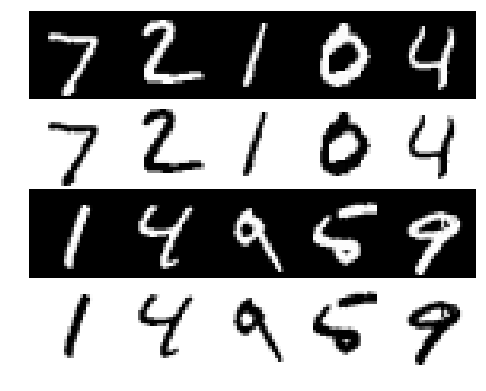

In [9]:
# plot original images 
# !!! validation data is not shuffled
mnist_generator = reversedMNISTGenerator()
inputs,_ = next(mnist_generator.nextVal())
input_x = inputs['input_x']
reversed_input_x = -input_x
# plot images
for ind_subrow in range(4):
    for ind_subcol in range(5):
        image_ind = int(np.floor(ind_subrow/2)*5+ind_subcol)
        if ind_subrow%2==0:
            if ind_subcol == 0:
                image_row = input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,input_x[image_ind]),axis=1)
        else:
            if ind_subcol == 0:
                image_row = reversed_input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,reversed_input_x[image_ind]),axis=1)
    if ind_subrow == 0:
        image_rows = image_row
    else:
        image_rows = np.concatenate((image_rows,image_row),axis=0)
        
plt.imshow(((np.squeeze(image_rows) + 1) * 127.5).astype(np.uint8),cmap='gray')
plt.axis('off')
# plt.savefig('mnist_sampled_orig.png',bbox_inches="tight")
plt.show()

In [13]:
# plot original images 
# !!! validation data is not shuffled
mnist_generator = reversedMNISTGenerator()
inputs,_ = next(mnist_generator.nextVal())
input_x = inputs['input_x']
reversed_input_x = -input_x

log_dir = 'logs_mnist_evenfive_mode_'+str(3)+'_gamma_0.01'
g_model_dir = log_dir+'/g_model_12_19_9.h5'
image_size = (28,28,1)
img_input = Input(image_size)
img_output = generator(img_input) 
g_model = Model(inputs=[img_input], outputs=[img_output])
g_model.load_weights(g_model_dir)  # load pretrained model if avialable

trans_input_x = g_model.predict(input_x)
trans_reversed_input_x = g_model.predict(reversed_input_x)
# plot images
for ind_subrow in range(4):
    for ind_subcol in range(5):
        image_ind = int(np.floor(ind_subrow/2)*5+ind_subcol)
        if ind_subrow%2==0:
            if ind_subcol == 0:
                image_row = trans_input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,trans_input_x[image_ind]),axis=1)
        else:
            if ind_subcol == 0:
                image_row = trans_reversed_input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,trans_reversed_input_x[image_ind]),axis=1)
    if ind_subrow == 0:
        image_rows = image_row
    else:
        image_rows = np.concatenate((image_rows,image_row),axis=0)
        
plt.imshow(((np.squeeze(image_rows) + 1) * 127.5).astype(np.uint8),cmap='gray')
plt.axis('off')
plt.savefig('des_mnist_sampled_orig.png',bbox_inches="tight")
# plt.show()

In [11]:
# plot desensitized images 
gammas = [0.01,0.1,1,10]
ind_mode = 3
col_nums = 20
image_size = (28,28,1)
row_len = int(28*col_nums)
row_gap = np.ones((28,row_len,1))
for ind_row in range(len(gammas)+1):
    if ind_row > 0:
        log_dir = 'logs_mnist_evenfive_mode_'+str(ind_mode)+'_gamma_'+str(gammas[ind_row-1])
        g_model_dir = log_dir+'/g_model_12_19_9.h5'

        img_input = Input(image_size)
        img_output = generator(img_input) 
        g_model = Model(inputs=[img_input], outputs=[img_output])
        g_model.load_weights(g_model_dir)  # load pretrained model if avialable

        trans_input_x = g_model.predict(input_x)
        trans_reversed_input_x = g_model.predict(reversed_input_x)
    for ind_col in range(col_nums):
        if ind_row == 0: # first row is the original images
            if ind_col == 0:
                image_row = input_x[0]
                continue
            if ind_col%2 ==0:
                image_row = np.concatenate((image_row,input_x[int(np.floor(ind_col/2))]),axis=1)
            else:
                image_row = np.concatenate((image_row,reversed_input_x[int(np.floor(ind_col/2))]),axis = 1)
        else:
            if ind_col == 0:
                image_row = trans_input_x[0]
                continue
            if ind_col%2 ==0:
                image_row = np.concatenate((image_row,trans_input_x[int(np.floor(ind_col/2))]),axis=1)
            else:
                image_row = np.concatenate((image_row,trans_reversed_input_x[int(np.floor(ind_col/2))]),axis = 1)
    if ind_row == 0:
        image_rows = image_row
        image_rows = np.concatenate((image_rows,row_gap),axis=0)
    else:
        image_rows = np.concatenate((image_rows,image_row),axis=0)
        image_rows = np.concatenate((image_rows,row_gap),axis=0)
                

In [12]:
plt.close()
fig_width = 4
fig_height = len(gammas)
plt.figure(figsize=(fig_width,fig_height),dpi=200)
plt.imshow(((np.squeeze(image_rows) + 1) * 127.5).astype(np.uint8),cmap='gray')
plt.axis('off')
# plt.show()
# plt.axis('off')
plt.savefig('3_privacynet_mnist_des.png',bbox_inches="tight")

# Test accuracy:  attack_model/task_model

In [13]:
def build_model(output_dim=10):
    img_input = Input((28,28,1))
    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img_input)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)
    
    y = Conv2D(output_dim, kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation='softmax')(y)
    pred = Flatten()(y)
    model = Model(inputs=img_input,outputs=pred)
    optimizer = Adam(lr=2e-5, decay=5e-9, beta_1=0.5, beta_2=0.999)
    model.compile(optimizer, loss=['categorical_crossentropy'],metrics=['acc'])
    return model
    
    

In [17]:
# train models
mnist_generator = reversedMNISTGenerator()
batch_size = 128
epochs = 12
x_train = mnist_generator.x_train
x_train = x_train / 127.5 - 1
x_test = mnist_generator.x_test
x_test = x_test / 127.5 - 1
y_train = mnist_generator.y_train
y_train = keras.utils.to_categorical(y_train,2)
y_test = mnist_generator.y_test
y_test = keras.utils.to_categorical(y_test,2)
u_train = mnist_generator.u_train
u_train = keras.utils.to_categorical(u_train,10)
u_test = mnist_generator.u_test
u_test = keras.utils.to_categorical(u_test,10)
attack_model = build_model(2)
attack_model.fit(x_train, y_train,
                  batch_size = batch_size, epochs = epochs, 
                  validation_data=(x_test,y_test))
task_model = build_model(10)
task_model.fit(x_train, u_train,
                  batch_size = batch_size, epochs = epochs, 
                  validation_data=(x_test,u_test))

Train on 120000 samples, validate on 20000 samples
Epoch 1/12
120000/120000 [==============================] - 16s 137us/step - loss: 0.0094 - acc: 0.9974 - val_loss: 3.6130e-05 - val_acc: 1.0000
Epoch 2/12
120000/120000 [==============================] - 13s 111us/step - loss: 1.0682e-04 - acc: 1.0000 - val_loss: 6.6080e-06 - val_acc: 1.0000
Epoch 3/12
120000/120000 [==============================] - 13s 112us/step - loss: 3.8730e-05 - acc: 1.0000 - val_loss: 3.2167e-06 - val_acc: 1.0000
Epoch 4/12
120000/120000 [==============================] - 13s 107us/step - loss: 1.8011e-05 - acc: 1.0000 - val_loss: 1.1931e-06 - val_acc: 1.0000
Epoch 5/12
120000/120000 [==============================] - 13s 108us/step - loss: 9.4998e-06 - acc: 1.0000 - val_loss: 5.9623e-07 - val_acc: 1.0000
Epoch 6/12
120000/120000 [==============================] - 13s 110us/step - loss: 5.5599e-06 - acc: 1.0000 - val_loss: 3.3928e-07 - val_acc: 1.0000
Epoch 7/12
120000/120000 [==============================] -

In [18]:
gammas = [0.01,0.1,1,10]
ind_mode = 3
for ind_gamma,gamma in enumerate(gammas):
    log_dir = 'logs_mnist_evenfive_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
    g_model_dir = log_dir+'/g_model_12_19_9.h5'
    # build generator
    img_input = Input(image_size)
#         if ind_mode == 0:
#             img_output = generatorV2(img_input)  # pass image into generator
#         elif ind_mode == 1:
#             img_output = generatorV3(img_input)  # pass image into generator
#         elif ind_mode == 2:
#             img_output = generatorV4(img_input)  # pass image into generator
#         else:
    img_output = generator(img_input) 
    g_model = Model(inputs=[img_input], outputs=[img_output])
    g_model.load_weights(g_model_dir)  # load pretrained model if avialable
#         g_model.summary()
    trans_x_test = g_model.predict(x_test)
    attack_eval = attack_model.evaluate(trans_x_test,y_test)
    print("mode:{},gamma:{},sensitive_accu:{}".format(ind_mode,gamma,attack_eval[1]))
    task_eval = task_model.evaluate(trans_x_test,u_test)
    print("mode:{},gamma:{},public_accu:{}".format(ind_mode,gamma,task_eval[1]))

20000/20000 [==============================] - 2s 108us/step
mode:3,gamma:0.01,sensitive_accu:0.5
20000/20000 [==============================] - 2s 106us/step
mode:3,gamma:0.01,public_accu:0.95315
20000/20000 [==============================] - 2s 104us/step
mode:3,gamma:0.1,sensitive_accu:0.5
20000/20000 [==============================] - 2s 104us/step
mode:3,gamma:0.1,public_accu:0.92095
20000/20000 [==============================] - 2s 105us/step
mode:3,gamma:1,sensitive_accu:0.5
20000/20000 [==============================] - 2s 99us/step
mode:3,gamma:1,public_accu:0.9611
20000/20000 [==============================] - 2s 104us/step
mode:3,gamma:10,sensitive_accu:0.5
20000/20000 [==============================] - 2s 100us/step
mode:3,gamma:10,public_accu:0.9237


# Plot losses:  training loss

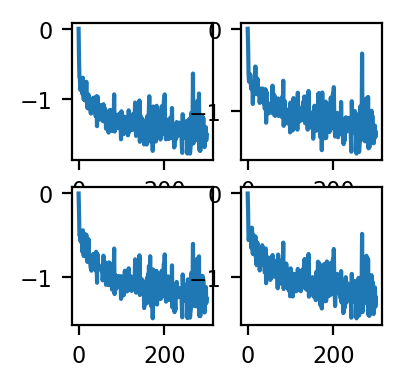

In [36]:
# plot desensitized images 
gammas = [0.01,0.1]
mode_num = 2
image_size = (28,28,1)
fig_height = len(gammas)
fig_width = mode_num
ind_list = [i for i in np.arange(0,1500,5)]
plt.close()
plt.figure(figsize=(fig_width,fig_height),dpi=200)

for ind_gamma,gamma in enumerate(gammas):
    for ind_mode in range(mode_num):
        plt_ind = ind_gamma * mode_num + ind_mode
        plt.subplot(fig_width,fig_height,plt_ind+1)
        log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        loss_dir = log_dir+'/result_loss_12_19_9.npy'
        loss_results = np.load(loss_dir)
        d_loss = loss_results.item()['loss_u']
        d_loss = d_loss[slice(0,1500,5)]
        g_loss = loss_results.item()['loss_y']
        g_loss = g_loss[slice(0,1500,5)]
        plt.plot(range(len(d_loss)),d_loss)
#         plt.plot(range(len(g_loss)),g_loss)
plt.show()
#         plt.ylim([0,255])
#         plt.title(str(plt_ind))
#         plt.xticks([])
#         plt.yticks([])